# Twitter Airline Sentiment Analysis (ULMFiT)

## Introduction

This notebook takes in the Dataset given to us [Twitter US Airline Sentiment Dataset](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) and then predict the tweet sentiment using a Universal Language Model Fine-tuning for Text Classification ([ULMFiT]).

## Setup

Packages that need to Imported

In [ ]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt

# Modeling, selection, and evaluation
from fastai.text import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels

%matplotlib inline 

# Data Preparation

First we read the data and explore the  columns that can be used.

In [ ]:
# Read file into dataframe
pd.set_option('display.max_colwidth', -1)
df = pd.read_csv('../input/Tweets.csv')
df = df.reindex(np.random.permutation(df.index))  
df.head()

Distribution of the dependent variable: airline_sentiment, and its breakdown across airlines and tweet length. 

In [ ]:
df['airline_sentiment'].value_counts().plot(kind='bar')

In [ ]:
df['airline'].value_counts().plot(kind='bar')

In [ ]:
df.groupby(['airline', 'airline_sentiment']).size().unstack().plot(kind='bar', stacked=True)

In [ ]:
df['tweet_length'] = df['text'].apply(len)
df.groupby(['tweet_length', 'airline_sentiment']).size().unstack().plot(kind='line', stacked=False)

We can see that there isn't a lot of correlation between the number of positive / neutral tweets and the tweet length, but for negative tweets the distribution is heavily skewed towards longer tweets. This is possibly because the angier the tweeter, the more they have to say. Next we'll see if the same observation can be made about the average and median sentiment confidence as well.

In [ ]:
df[['tweet_length', 'airline_sentiment', 'airline_sentiment_confidence']].groupby(['tweet_length', 'airline_sentiment']).mean().unstack().plot(kind='line', stacked=False)

In [ ]:
df[['tweet_length', 'airline_sentiment', 'airline_sentiment_confidence']].groupby(['tweet_length', 'airline_sentiment']).median().unstack().plot(kind='line', stacked=False)

There isn't much of a relatable relationship between the confidence and the tweet length. Next we  will randomize and split the data, then write to CSVs. 

In [ ]:
test_percentage = 0.1
df.sort_index(inplace=True)
cutoff = int(test_percentage * df.shape[0])
df[['airline_sentiment', 'text']][:cutoff].to_csv('Tweets_filtered_test.csv', index=False, encoding='utf-8')
df[['airline_sentiment', 'text']][cutoff:].to_csv('Tweets_filtered_train.csv', index=False, encoding='utf-8')
df[['text']][cutoff:].to_csv('Tweets_text_only_train.csv', index=False, encoding='utf-8')

### Tokenization

We read the data and add new words to the dictionary, and we will create representations of words using numbers.. 

In [ ]:
data = TextClasDataBunch.from_csv('.', 'Tweets_filtered_train.csv')
data.show_batch()

The following changes have been made to the text for ease of modeling:
- split on space and punctuation symbols
- the "'s" are grouped together in one token
- the contractions are separated like this: "did", "n't"
- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below)

In [ ]:
data.vocab.itos[:10]

Looking into the dataset we can now see the current representation post-processing, in both text form and numerical.

In [ ]:
print(data.train_ds[0][0])
print(data.train_ds[1][0])
print(data.train_ds[2][0])

In [ ]:
print(data.train_ds[0][0].data[:10])
print(data.train_ds[1][0].data[:10])
print(data.train_ds[2][0].data[:10])

## Language Model

We'll be using a language model provided from the fastai library and applying the pre-calculated weights from wikitext-103. This will provide a word embedding scheme that aligns with the corpus of airline tweets and will hopefully capture sufficient "meaning" in each word. The language model here will not be optimal as tweets sometimes do not obey conventional spelling and grammar, especially hastags. 

In [ ]:
bs = 24
seed = 333

First we ingest the data once again but have a 10% holdout only since we'll be using it to calibrate the language model. 

In [ ]:
data_lm = (TextList.from_csv('.', 'Tweets_text_only_train.csv')
            .random_split_by_pct(0.1, seed = seed)
           #We randomly split and keep 10% for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [ ]:
# data_lm = load_data(path, 'data_lm.pkl', bs=bs)
data_lm.show_batch()

Now we define the language model and set the learning rates. 

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot(skip_end=15)

Next we fit the model for a few cycles by running 1 epoch and then unfreezing and running more epochs to fine tune.  

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

In [ ]:
learn.save('fit_head')
# learn.load('fit_head')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

In [ ]:
learn.save('fine_tuned')

In [ ]:
learn.save_encoder('fine_tuned_enc')

The language model didn't show the expected results.  This is likely due to the fact that tweets dont always follow proper English spelling and grammar, making it difficult for the model to correctly predict. 

## Classifier

Next we'll use the encoder from the language model in our classifier, which has a similar LSTM architecture but will predict the sentiment instead of the next word in a tweet. The model architecture here presents some advantages over traditional bags-of-words 

In [33]:
data_clas = (TextList.from_csv('.', 'Tweets_filtered_train.csv', cols = 'text')               
             .random_split_by_pct(0.1, seed = seed)
             .label_from_df(cols=0)
             .databunch(bs=bs))
data_clas.save('data_clas.pkl')
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup xxunk - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup xxunk 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag allowance for xxup jac - xxup lax,neutral
xxbos @usairways xxmaj my xxmaj flight xxmaj booking xxmaj problems xxup xxunk just times out when i select it under xxmaj manage xxmaj my xxmaj flight xxmaj booking xxmaj problems for months now . i have emailed but no response . xxmaj help,negative
xxbos @united xxmaj missed xxup xxunk flight due to ur xxmaj cancelled xxmaj flightlation . xxmaj xxunk supervisor disgusting . xxmaj now day xxmaj late xxmaj flight . xxmaj no apology or upgrade offer to xxup lhr from xxup ord ? ?,negative
xxbos @usairways i 've been on hold for over 2 1 / 2 hours - there has to be an easier way to xxmaj cancelled xxmaj flight / get a refund ... 😑 😩 http : / / t.co /,negative
"xxbos @southwestair xxmaj hi ! xxmaj winter xxmaj xxunk xxmaj advisory issued for xxup stl . xxmaj snow & & xxmaj ice & & xxmaj cold , oh my ! xxmaj will you issue a travel advisory for that",neutral


In [34]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


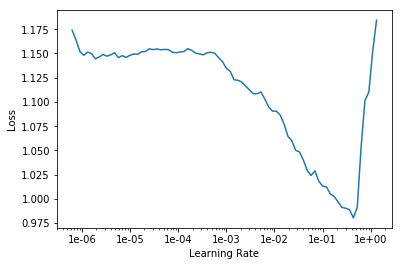

In [36]:
learn.recorder.plot()

We train by gradually unfreezing layers and then running an epoch each time, in accordance with the suggestions in the ULMFiT paper.

In [37]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.618032,0.519811,0.792711,00:08


In [38]:
learn.save('first')
# learn.load('first)

In [39]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.612687,0.497983,0.800304,00:09


In [40]:
learn.save('second')
# learn.load('second')

In [41]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.574817,0.496480,0.809415,00:14


In [42]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.507679,0.469228,0.813971,00:18
1,0.521484,0.454676,0.817008,00:18
2,0.523521,0.453216,0.813971,00:17


### Evaluate Performance on Test Set

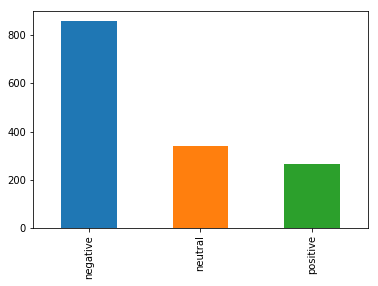

In [43]:
test_df = pd.read_csv("Tweets_filtered_test.csv", encoding="utf-8")
test_df['airline_sentiment'].value_counts().plot(kind='bar')

In [45]:
test_df['pred_sentiment'] = test_df['text'].apply(lambda row: str(learn.predict(row)[0]))
print("Test Accuracy: ", accuracy_score(test_df['airline_sentiment'], test_df['pred_sentiment']))

Test Accuracy:  0.7827868852459017


In [46]:
test_df[:20]

,airline_sentiment,text,pred_sentiment
0,neutral,@VirginAmerica What @dhepburn said.,neutral
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,negative
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,negative
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
4,negative,@VirginAmerica and it's a really big bad thing about it,positive
5,negative,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,negative
6,positive,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",negative
7,neutral,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",negative
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D",negative
9,positive,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",positive


Plot confusion matrix to see where the areas of misclassification are. 

In [49]:
# Confusion matrix plotting adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

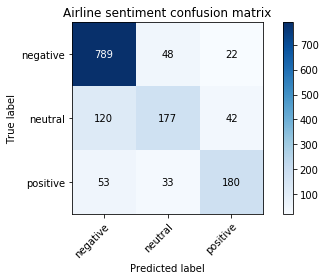

In [50]:
plot_confusion_matrix(test_df['airline_sentiment'], test_df['pred_sentiment'], classes=['negative', 'neutral', 'positive'], title='Airline sentiment confusion matrix')
# confusion_matrix(test_df['airline_sentiment'], test_df['pred_sentiment'], labels=['positive', 'neutral', 'negative'])
plt.show()

From the confusion matrix, we can see that within True Negatives, the prediction accuracy is pretty high. The model has a very hard time classifying neutral tweets, and often misclassifies them as negative. For True Positives, the overall accuracy is pretty good but a surprisingly large number get classified as negative. Let's look at these in closer detail:

In [51]:
test_df.loc[(test_df['airline_sentiment'] == 'positive') & (test_df['pred_sentiment'] == 'negative')]

,airline_sentiment,text,pred_sentiment
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,negative
6,positive,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",negative
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D",negative
19,positive,@VirginAmerica you know what would be amazingly awesome? BOS-FLL PLEASE!!!!!!! I want to fly with only you.,negative
64,positive,@VirginAmerica @ladygaga @carrieunderwood love all three but you really can't beat the classics!,negative
114,positive,@VirginAmerica come back to #PHL already. We need you to take us out of this horrible cold. #pleasecomeback http://t.co/gLXFwP6nQH,negative
203,positive,@VirginAmerica cool picture of another VirginAmerica plane off our wing. What a site! http://t.co/5B2agFd8c4,negative
273,positive,@VirginAmerica cutest salt and pepper shaker ever. Just when I think you guys can't get any better you just do! http://t.co/vC6Keulg2J,negative
307,positive,"@VirginAmerica I mean. Probably inappropriate while on board.. But, it's on!",negative
323,positive,@VirginAmerica How about some free drinks on the flight back for the free promo?,negative


It's not immediately clear what the common thread that led these tweets to be mislabelled but possible causes include missing signals from hastags, non-grammatical sentences, mis-spellings, etc. which generally contribute to the classification error. 

In the future, it would be good to spend more time on feature engineering and fitting the language model so that it's more suited to the vocabulary and style of language that is in tweets. From the language model and processing steps, we can see that the model accuracy is not very high and that, even as humans, it's hard to discern the sentiment from the post-processed / tokenized text. One possible way of addressing this issue is to use a much larger corpus of tweets when developing the language model. 